In [71]:
indir = "Z:/Cerebellum Team/Nathaly/ines"
filename = indir + '/Yellow_mit1-6.tif'

n_skip_slices = 0
channel = 0

voxel_size_nm = (141.76,141.76,300) # This is same as the voxel size in nanometers
objfile = "/".join(filename.split("/")[:-1]) + "/" + "".join(filename.split("/")[-1].split(".")[:-1]) + ".obj"

In [72]:
#Try opening file with PIL
#img = Image.open(filename)
#n_images = img.n_frames
#image =[]
#print (f'your file contains: {n_images} frames')

In [73]:
# Open using tiffile
image = tiffile.imread(filename)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


In [74]:
import cv2
import skimage
import matplotlib.pyplot as plt
import stackview
from PIL import Image, ImageDraw
import tiffile
import numpy as np
from skimage.filters import threshold_otsu
from skimage import measure
import scipy

import pyvista as pv

In [75]:
image.shape

(6, 888, 648)

In [86]:
img = image[n_skip_slices:,:,:]<1
img.shape

(6, 888, 648)

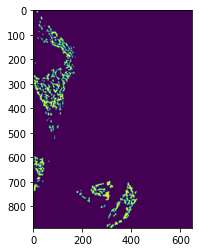

In [87]:
plt.imshow(img[0])

In [88]:
stackview.slice(img, axis=0, continuous_update=True)

In [89]:
img.shape, img.dtype.name

((6, 888, 648), 'bool')

In [90]:
img = img.astype(np.uint64)

In [91]:
img.dtype.name

'uint64'

In [92]:
img.min(), img.max()

(0, 1)

In [93]:
zproj_max = np.max(img, axis=0)
zproj_avg = np.mean(img, axis=0)
zproj_sum = np.sum(img, axis=0)

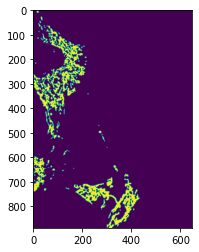

In [94]:
plt.imshow(zproj_max)

In [95]:
#a = zproj_max[zproj_max>50000]
#plt.imshow(zproj_max>50000)

In [96]:
thresh = threshold_otsu(zproj_max.astype(np.int64))
print(thresh)
binary = zproj_max 

0


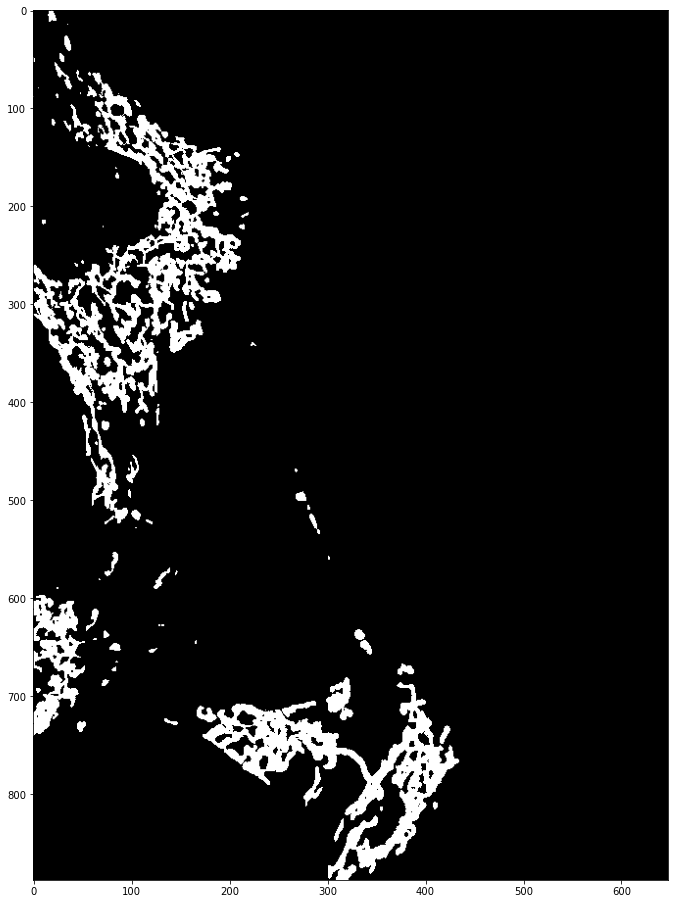

In [97]:
plt.figure(figsize=(16,16))
plt.imshow(binary, cmap=plt.cm.gray)

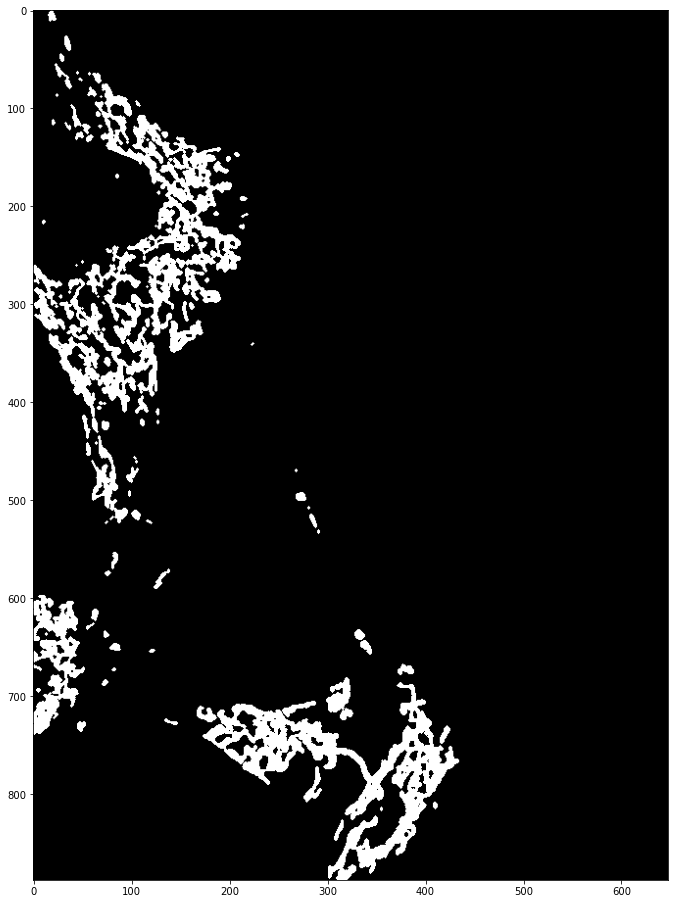

In [98]:


mask = scipy.ndimage.binary_opening(binary, iterations=1)

#mask = scipy.ndimage.binary_erosion(mask, iterations=1)

mask = scipy.ndimage.binary_fill_holes(mask, structure=np.ones((12,12)))


#mask = scipy.ndimage.binary_dilation(mask, iterations=5)

plt.figure(figsize=(16,16))
plt.imshow(mask, cmap=plt.cm.gray)

In [99]:
thresh = threshold_otsu(img.astype(np.int64))
print(thresh)
binary_img = img
thresh-10000

0


-10000

In [100]:
stackview.slice(binary_img, axis=0, continuous_update=True)

In [101]:
mask = binary_img
#mask = scipy.ndimage.binary_opening(binary_img, iterations=1)

#mask = scipy.ndimage.binary_dilation(mask, iterations=1)
#mask = scipy.ndimage.binary_erosion(mask, iterations=1)

mask = scipy.ndimage.binary_fill_holes(mask)#, structure=np.ones((12,12,12)))


#mask = scipy.ndimage.binary_dilation(mask, iterations=5)

mask.shape
stackview.slice(mask, axis=0, continuous_update=True)

In [102]:
zproj_max = np.max(mask, axis=0)

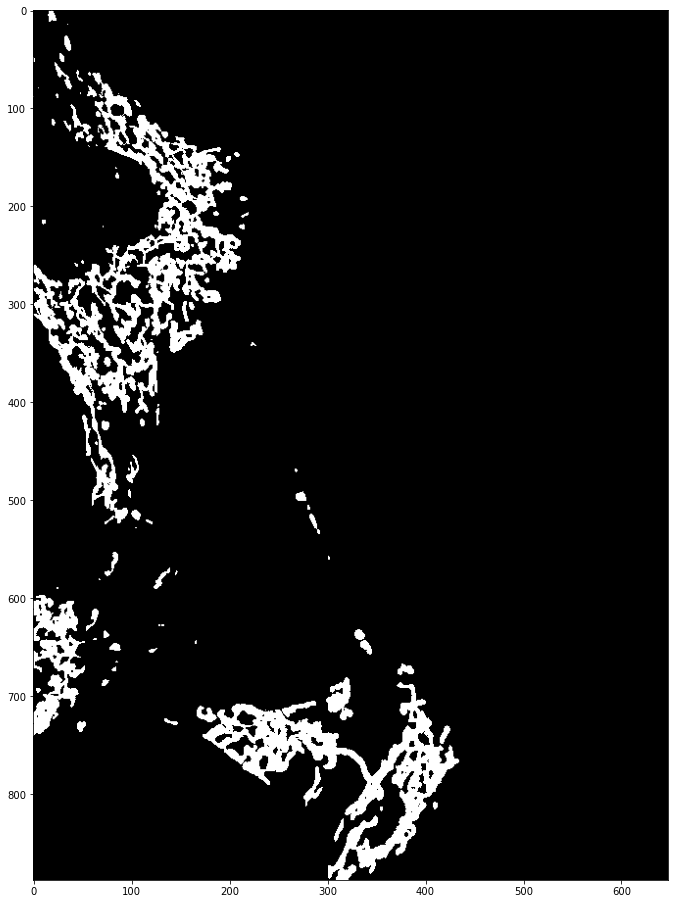

In [103]:
plt.figure(figsize=(16,16))
plt.imshow(zproj_max, cmap=plt.cm.gray)

In [104]:
def get_obj(obj_name='default_obj', verts=None, edges=None, faces=None, v_num_offset=0, material_class='default'):
    # Function to create obj format string which can be written to an obj file.
    obj = "o " + str(obj_name) + "\n"
  
    for item in verts:
        obj += "v {0} {1} {2}\n".format('{:.6f}'.format(item[0]),
                                          '{:.6f}'.format(item[1]),
                                          '{:.6f}'.format(item[2]))

    if material_class.strip() == '':
        material_class = 'default'
    obj += "usemtl " + material_class + "\n"
  
    for item in faces:
        obj += "f " + " ".join([str(x+v_num_offset) for x in item]) + "\n"
    v_num_offset += len(verts)

    return(obj, v_num_offset)

In [105]:
# Create obj from mask image
verts, faces, normals, values = measure.marching_cubes(mask, 0, step_size=4)
faces = faces+1 # This is required to start vertex numbers from 1, according to obj file format
verts.shape, faces.shape

((4187, 3), (5484, 3))

In [106]:
# Convert vertices from pixel to nanometer scale. Notice the z,x,y order of voxel size.
verts = verts * np.array([voxel_size_nm[2], voxel_size_nm[0], voxel_size_nm[1]])

In [107]:
# convert vertices to micrometer
verts = verts*0.001

In [108]:
# Do this only when you want to shift the image centroid to origin
#verts_centroid = np.mean(verts, axis=0)
#print(verts_centroid)
#verts = (verts - verts_centroid)/100
#verts.shape

In [109]:
v_num_offset = 0
obj, v_num_offset = get_obj(obj_name='connection', verts=verts, faces=faces, v_num_offset=v_num_offset, material_class='default')

In [110]:
with open(objfile,'w') as o:
    o.write(obj)

In [111]:
objfile

'Z:/Cerebellum Team/Nathaly/ines/Yellow_mit1-6.obj'

In [ ]:
indir = "Z:/Cerebellum Team/Nathaly/ines"
filename = indir + '/Yellow_mit1-6.tif'

n_skip_slices = 0
channel = 0

voxel_size_nm = (141.76,141.76,300) # This is same as the voxel size in nanometers
objfile = "/".join(filename.split("/")[:-1]) + "/" + "".join(filename.split("/")[-1].split(".")[:-1]) + ".obj"


In [1]:
import tifffile
import numpy as np
from scipy import ndimage as ndi

import napari

from skimage.segmentation import watershed
from skimage.feature import peak_local_max


indir = "Z:/Cerebellum Team/Nathaly/ines"
filename = indir + '/Yellow_mit1-6.tif'

nuclei = tifffile.imread(filename)

print("shape: {}".format(nuclei.shape))
print("dtype: {}".format(nuclei.dtype))
print("range: ({}, {})".format(np.min(nuclei), np.max(nuclei)))

shape: (6, 888, 648)
dtype: uint8
range: (0, 255)


In [3]:
spacing = np.array([0.216, 0.216, 0.6978])

In [4]:
viewer = napari.view_image(
    nuclei,
    contrast_limits=[0, 1],
    scale=spacing,
    ndisplay=3,
)
